In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
print(tf.__version__)

2.5.0


# Sentiment Analysis

* trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review
* This is an example of binary—or two-class—classification

**Large Movie Review Dataset**: contains the text of 50,000 movie reviews from the Internet Movie Database. 
* These are split into 25,000 reviews for training and 25,000 reviews for testing. 
* The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.

## I. Download and explore the IMDB dataset

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 5s 0us/step


In [4]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

* The **aclImdb/train/pos** and **aclImdb/train/neg** directories contain many text files, each of which is a single movie review. 
* Let's take a look at one of them.

In [6]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


## II. Loading the dataset

* We will load the data off disk and prepare it into a format suitable for training. 
* To do so, we will use the helpful **text_dataset_from_directory** utility, which expects a directory structure as follows.

main_directory/<br />
...class_a/<br />
......a_text_1.txt<br />
......a_text_2.txt<br />
...class_b/<br />
......b_text_1.txt<br />
......b_text_2.txt<br />

* To prepare a dataset for binary classification, we will need two folders on disk, corresponding to class_a and class_b. 
* These will be the positive and negative movie reviews, which can be found in aclImdb/train/pos and aclImdb/train/neg.
* As the IMDB dataset contains additional folders, we will remove them before using this utility.

In [9]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

* Next, we will use the text_dataset_from_directory utility to create a labeled **tf.data.Dataset**. 
* tf.data is a powerful collection of tools for working with data.

* When running a machine learning experiment, it is a best practice to divide the dataset into three splits: train, validation, and test.

* The IMDB dataset has already been divided into train and test, but it lacks a validation set. 
* Let's create a validation set using an 80:20 split of the training data by using the validation_split argument below.

In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


* There are 25,000 examples in the training folder, of which we will use 80% (or 20,000) for training. 
* We can also train a model by passing a dataset directly to **model.fit**. 
* We can also iterate over the dataset and print out a few examples as follows.

In [11]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

* Notice the reviews contain raw text (with punctuation and occasional HTML tags.
* The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, check the **class_names** property on the dataset.


In [12]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [13]:
# creating a validation and test data set
# we will use the remaining 5,000 reviews from the training set for validation.

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [14]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


## III. Preparing the dataset for training

* We will now standardize, tokenize, and vectorize the data using the helpful **preprocessing.TextVectorization** layer.

**Standardization** refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset.<br />
**Tokenization** refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace).<br />
**Vectorization** refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.


* Note that the various HTML tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). 
* Instead, we will write a custom standardization function to remove the HTML.

In [15]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

* Next, we will create a TextVectorization layer. 
* This layer is used to standardize, tokenize, and vectorize our data.
* We will set the output_mode to int to create unique integer indices for each token.

* Note that we're using the default split function, and the custom standardization function defined above. 
* We'll also define some constants for the model, like an explicit maximum sequence_length, which will cause the layer to pad or truncate sequences to exactly sequence_length values.

In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

* Next, we will call **adapt** to fit the state of the preprocessing layer to the dataset. T
* This will cause the model to build an index of strings to integers.

Note that it's important to only use the training data when calling adapt (using the test set would leak information).


In [17]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

* Let's create a function to see the result of using this layer to preprocess some data.

In [19]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [20]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  85,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2421,
           1,   51,   22,   25,  404,  251,   12,  308,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

* Notice that each token has been replaced by an integer. 
* We can lookup the token (string) that each integer corresponds to by calling **.get_vocabulary()** on the layer.

In [21]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  lovely
 313 --->  american
Vocabulary size: 10000


In [22]:
# applying the TextVectorization layer we created earlier to the train, validation, and test dataset.

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# IV. Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

**.cache()** keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training the model. If the dataset is too large to fit into memory, we can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.


**.prefetch()** overlaps data preprocessing and model execution while training.

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# V. Creating the Model

In [24]:
embedding_dim = 16

In [25]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

* The first layer is an Embedding layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).
* Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
* The last layer is densely connected with a single output node.


Next, we need to configure the model to use an optimizer and a loss function.

* Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we will use the **losses.BinaryCrossentropy** loss function.
    

In [27]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

# VI. Training the Model

In [28]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 8s 12ms/step - loss: 0.6642 - binary_accuracy: 0.6959 - val_loss: 0.6157 - val_binary_accuracy: 0.7730
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5493 - binary_accuracy: 0.8002 - val_loss: 0.4991 - val_binary_accuracy: 0.8236
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4455 - binary_accuracy: 0.8447 - val_loss: 0.4208 - val_binary_accuracy: 0.8470
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3792 - binary_accuracy: 0.8660 - val_loss: 0.3745 - val_binary_accuracy: 0.8608
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3360 - binary_accuracy: 0.8789 - val_loss: 0.3458 - val_binary_accuracy: 0.8668
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3051 - binary_accuracy: 0.8882 - val_loss: 0.3266 - val_binary_accuracy: 0.8702
Epoch 7/10
625/625 [==============================] - 3s 4ms/st

# VII. Evaluating the Model

In [29]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 13s 16ms/step - loss: 0.3108 - binary_accuracy: 0.8729 1s - loss: 0
Loss:  0.31084150075912476
Accuracy:  0.8728799819946289


In [30]:
# create a plot of accuracy and loss over time
# model.fit() returns a History object that contains a dictionary with everything that happened during training

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

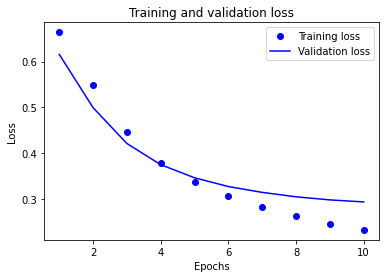

In [31]:
# There are four entries: one for each monitored metric during training and validation. 
# We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

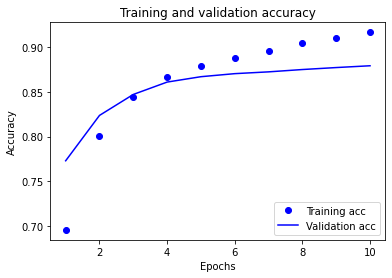

In [32]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# VII. Export the model

* Ihe code above, we applied the TextVectorization layer to the dataset before feeding text to the model. 
* If we want to make your model capable of processing raw strings (for example, to simplify deploying it), we can include the TextVectorization layer inside the model. 
* To do so, let's create a new model using the weights we just trained.
* Then we can call model.predict() to get predictions for the new examples

In [33]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 7s 9ms/step - loss: 0.3108 - accuracy: 0.8729
0.8728799819946289


In [34]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.5933676 ],
       [0.4155306 ],
       [0.33724603]], dtype=float32)